In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Load & Initial Inspection
# Load data
df = pd.read_csv('beijing_air_quality.csv')
print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
display(df.head())
print(f"\nLast 5 rows:")
display(df.tail())

# Check data types
print("\nDATA TYPES:")
print(df.dtypes)
print(f"\nMemory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

DATASET OVERVIEW
Shape: (43824, 13)

Columns: ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

First 5 rows:


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0



Last 5 rows:


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0



DATA TYPES:
No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

Memory usage: 4.35 MB


MISSING VALUES ANALYSIS
       Missing_Count  Percentage
pm2.5           2067    4.716594


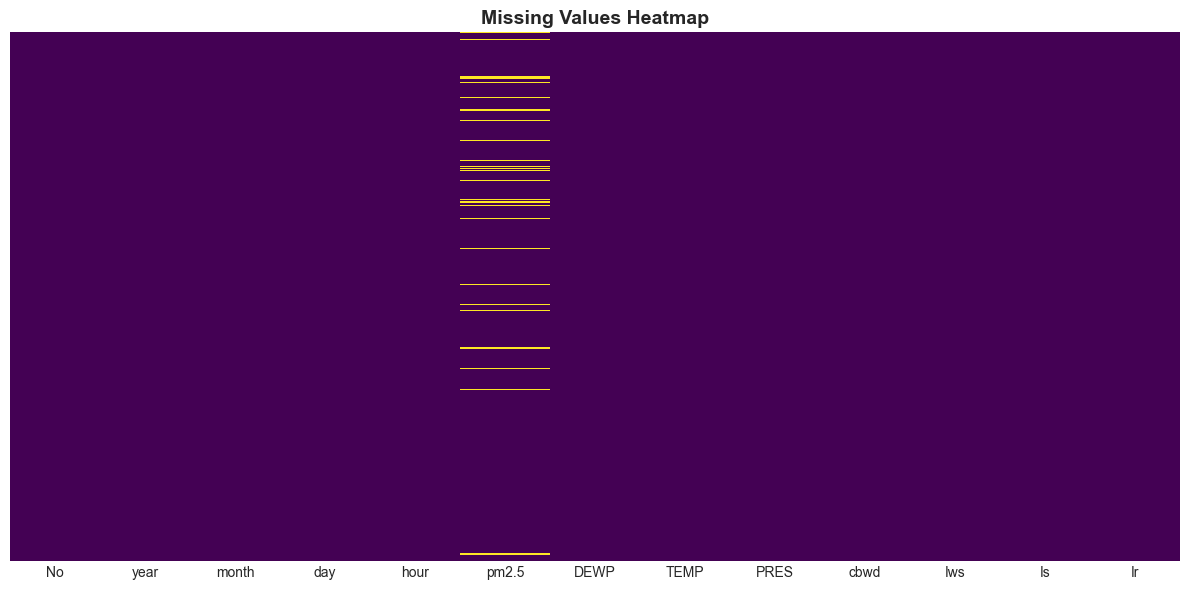


Missing PM2.5 by Year-Month:
year_month
2010-01     91
2010-02      1
2010-03     35
2010-04      2
2010-05      7
2010-06    155
2010-08     68
2010-09    252
2010-10      2
2010-11     56
Name: pm2.5, dtype: int64


In [ ]:
# 2. Handle Missing Values
print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Total missing per column
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Check missing pattern by year/month
print("\nMissing PM2.5 by Year-Month:")
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
pm25_missing_by_month = df.groupby('year_month')['pm2.5'].apply(lambda x: x.isnull().sum())
print(pm25_missing_by_month[pm25_missing_by_month > 0].head(10))

In [ ]:
# 3. Create Datetime Index & Check Duplicates
print("="*50)
print("TIME-SERIES STRUCTURE")
print("="*50)

# Create datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Check time range and frequency
print(f"Time range: {df.index.min()} to {df.index.max()}")
print(f"Expected hours: {(df.index.max() - df.index.min()).days * 24 + 24}")
print(f"Actual hours: {len(df)}")
print(f"Missing hours: {(df.index.max() - df.index.min()).days * 24 + 24 - len(df)}")

# Check for duplicates
print(f"\nTotal duplicates: {df.duplicated().sum()}")
print(f"Datetime duplicates: {df.index.duplicated().sum()}")

# Remove datetime duplicates if any
if df.index.duplicated().any():
    print("Removing datetime duplicates...")
    df = df[~df.index.duplicated(keep='first')]
    print(f"New shape: {df.shape}")

TIME-SERIES STRUCTURE
Time range: 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Expected hours: 43824
Actual hours: 43824
Missing hours: 0

Total duplicates: 0
Datetime duplicates: 0


PM2.5 MISSING VALUE HANDLING
PM2.5 missing before: 2067 (4.72%)


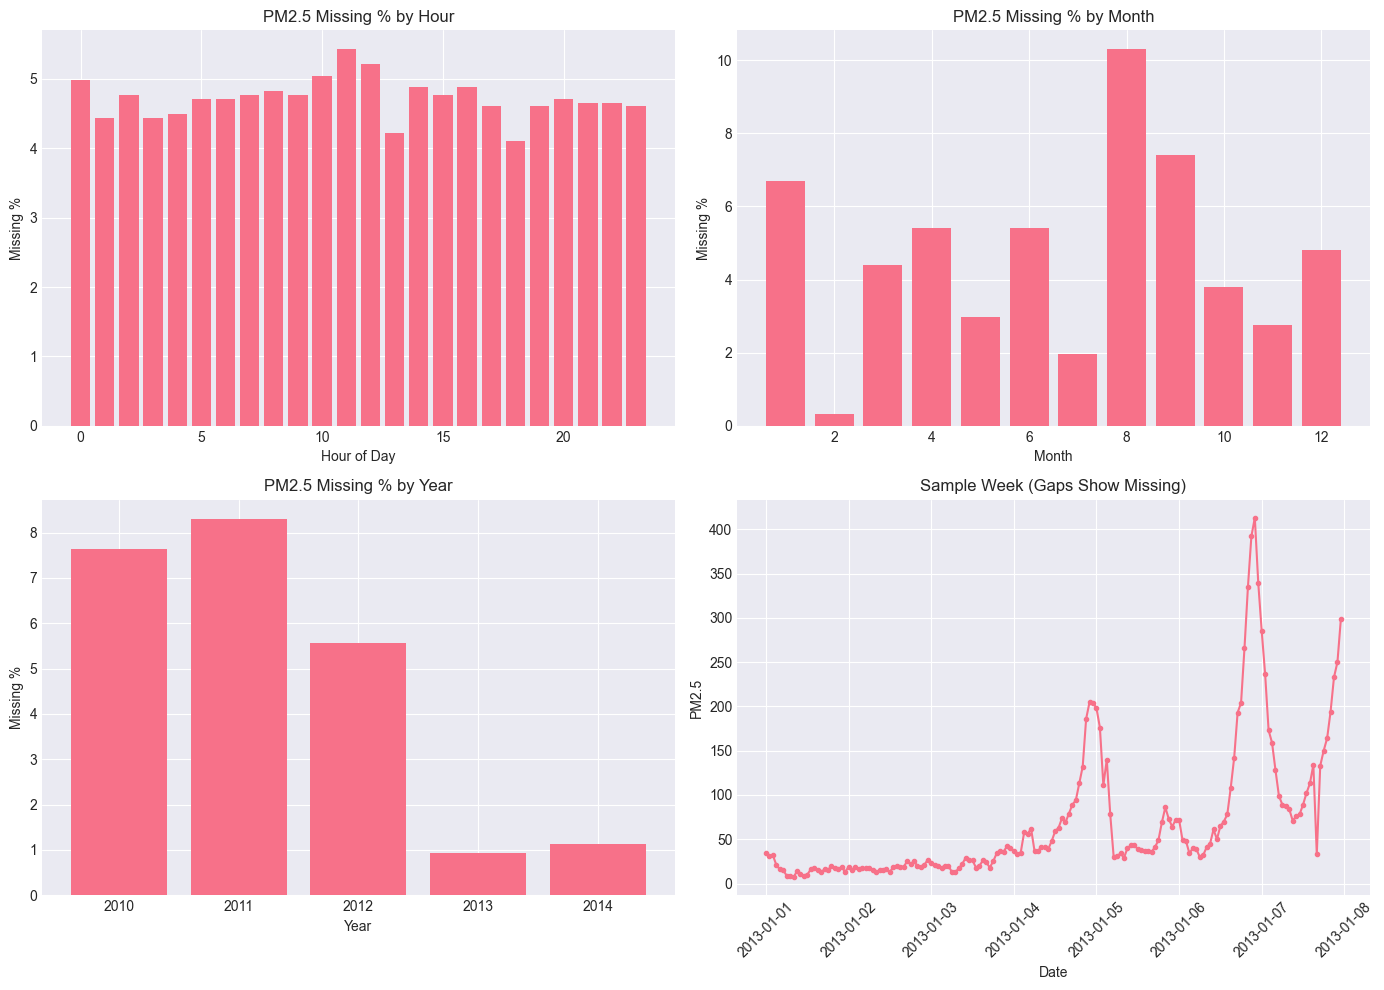

PM2.5 missing after imputation: 0


In [ ]:
# 4. Handle PM2.5 Missing Values
print("="*50)
print("PM2.5 MISSING VALUE HANDLING")
print("="*50)

# Before imputation stats
original_missing = df['pm2.5'].isnull().sum()
print(f"PM2.5 missing before: {original_missing} ({original_missing/len(df)*100:.2f}%)")

# Plot missing pattern
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Missing by hour
missing_by_hour = df.groupby('hour')['pm2.5'].apply(lambda x: x.isnull().mean())
axes[0,0].bar(missing_by_hour.index, missing_by_hour.values * 100)
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Missing %')
axes[0,0].set_title('PM2.5 Missing % by Hour')

# Missing by month
missing_by_month = df.groupby('month')['pm2.5'].apply(lambda x: x.isnull().mean())
axes[0,1].bar(missing_by_month.index, missing_by_month.values * 100)
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Missing %')
axes[0,1].set_title('PM2.5 Missing % by Month')

# Missing by year
missing_by_year = df.groupby('year')['pm2.5'].apply(lambda x: x.isnull().mean())
axes[1,0].bar(missing_by_year.index, missing_by_year.values * 100)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Missing %')
axes[1,0].set_title('PM2.5 Missing % by Year')

# Time-series plot showing gaps
sample_week = df.loc['2013-01-01':'2013-01-07', 'pm2.5']
axes[1,1].plot(sample_week.index, sample_week.values, marker='o', markersize=3)
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('PM2.5')
axes[1,1].set_title('Sample Week (Gaps Show Missing)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Impute missing values - forward fill then backward fill
df['pm2.5_original'] = df['pm2.5'].copy()  # Keep original for comparison
df['pm2.5'] = df['pm2.5'].fillna(method='ffill').fillna(method='bfill')

print(f"PM2.5 missing after imputation: {df['pm2.5'].isnull().sum()}")

BASIC STATISTICS

DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,dtype
No,43824.0,21912.500000,12651.043435,1.00,10956.75,21912.50,32868.25,43824.0,0,0.000000,int64
year,43824.0,2012.000000,1.413842,2010.00,2011.00,2012.00,2013.00,2014.0,0,0.000000,int64
month,43824.0,6.523549,3.448572,1.00,4.00,7.00,10.00,12.0,0,0.000000,int64
day,43824.0,15.727820,8.799425,1.00,8.00,16.00,23.00,31.0,0,0.000000,int64
hour,43824.0,11.500000,6.922266,0.00,5.75,11.50,17.25,23.0,0,0.000000,int64
pm2.5,43824.0,97.801114,91.376429,0.00,29.00,72.00,136.00,994.0,0,0.000000,float64
DEWP,43824.0,1.817246,14.433440,-40.00,-10.00,2.00,15.00,28.0,0,0.000000,int64
TEMP,43824.0,12.448521,12.198613,-19.00,2.00,14.00,23.00,42.0,0,0.000000,float64
PRES,43824.0,1016.447654,10.268698,991.00,1008.00,1016.00,1025.00,1046.0,0,0.000000,float64
Iws,43824.0,23.889140,50.010635,0.45,1.79,5.37,21.91,585.6,0,0.000000,float64


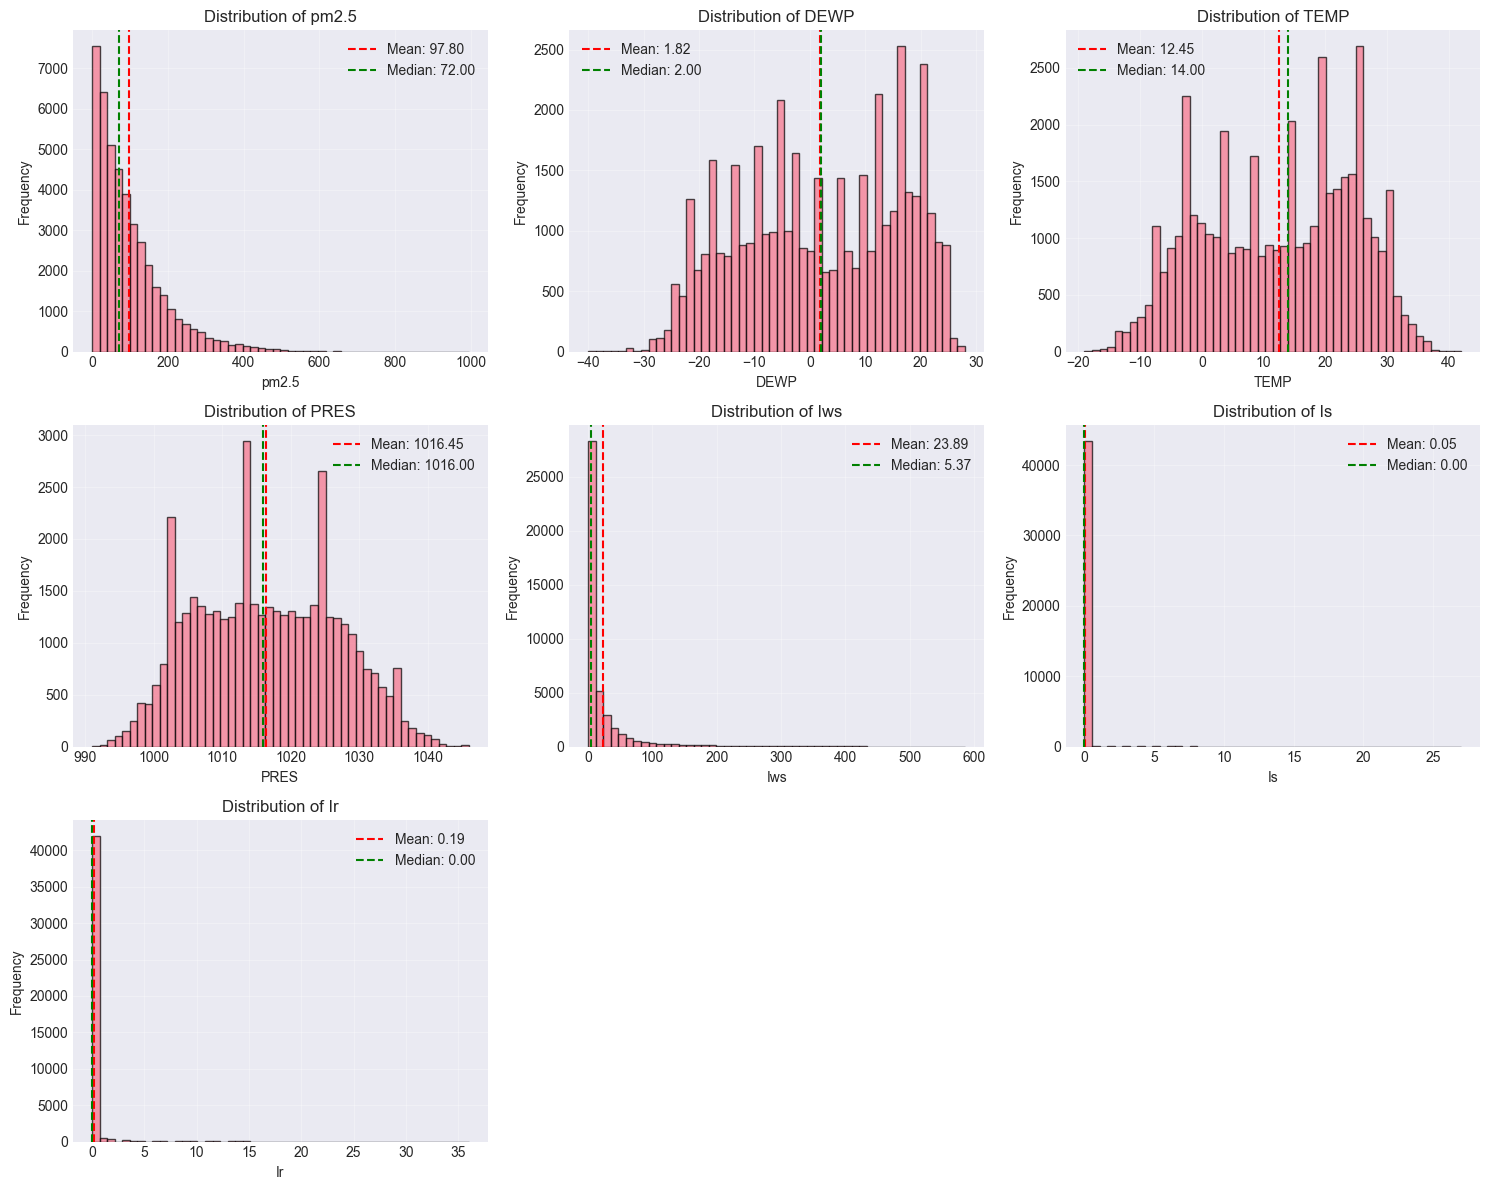

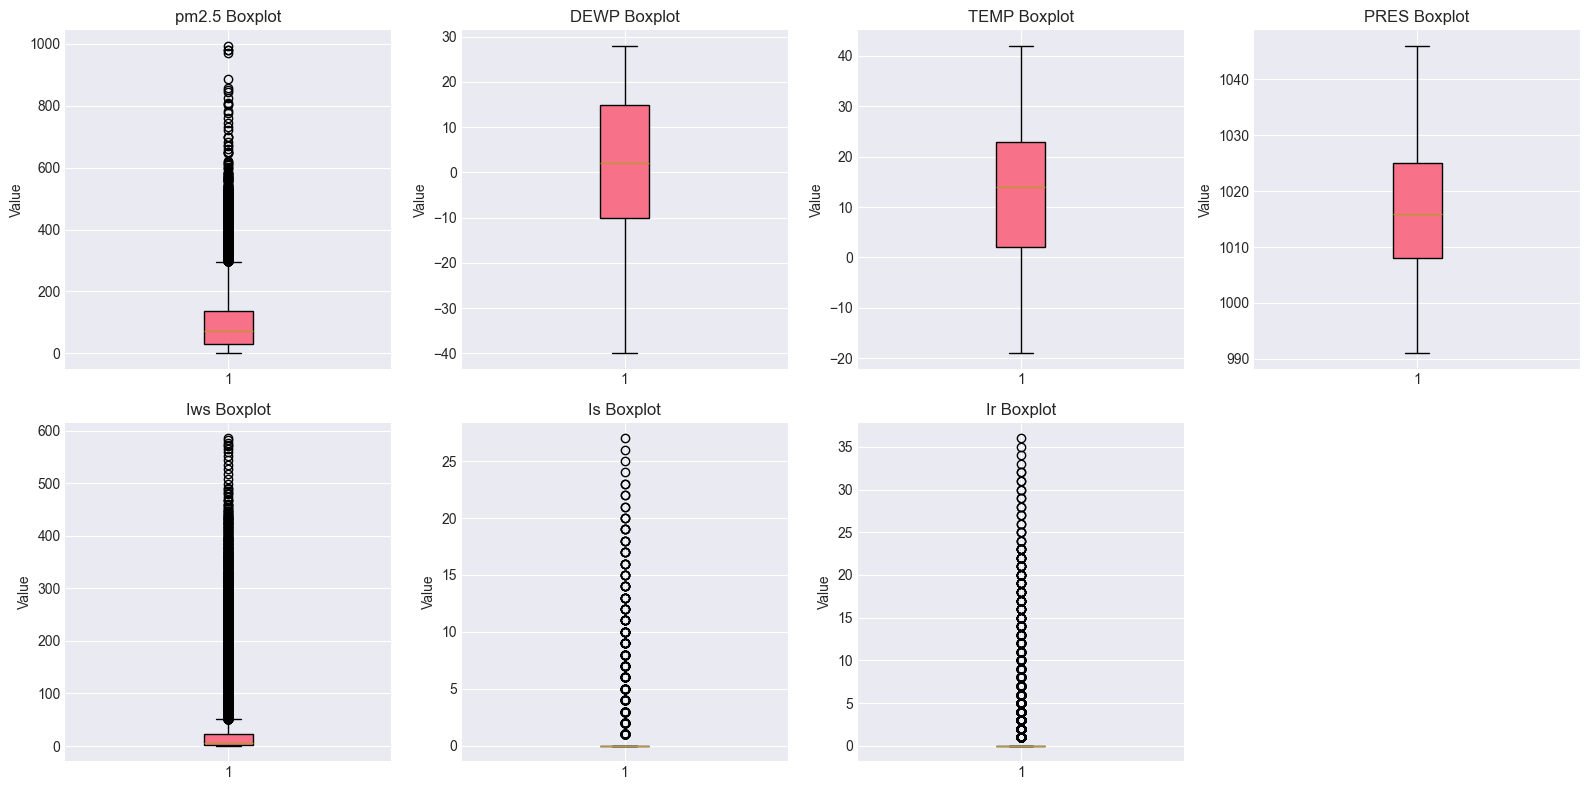

In [ ]:
# 5. Basic Statistics & Distribution
print("="*50)
print("BASIC STATISTICS")
print("="*50)

# Descriptive stats
print("\nDESCRIPTIVE STATISTICS:")
stats_df = df.describe().T
stats_df['missing'] = df.isnull().sum()
stats_df['missing_pct'] = (df.isnull().sum() / len(df)) * 100
stats_df['dtype'] = df.dtypes
display(stats_df)

# Distribution plots
numeric_cols = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        # Histogram
        axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
        axes[idx].axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.2f}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

# Remove empty subplots
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Boxplots to identify outliers
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True)
    axes[idx].set_title(f'{col} Boxplot')
    axes[idx].set_ylabel('Value')

# Remove empty subplots
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

TIME-SERIES ANALYSIS


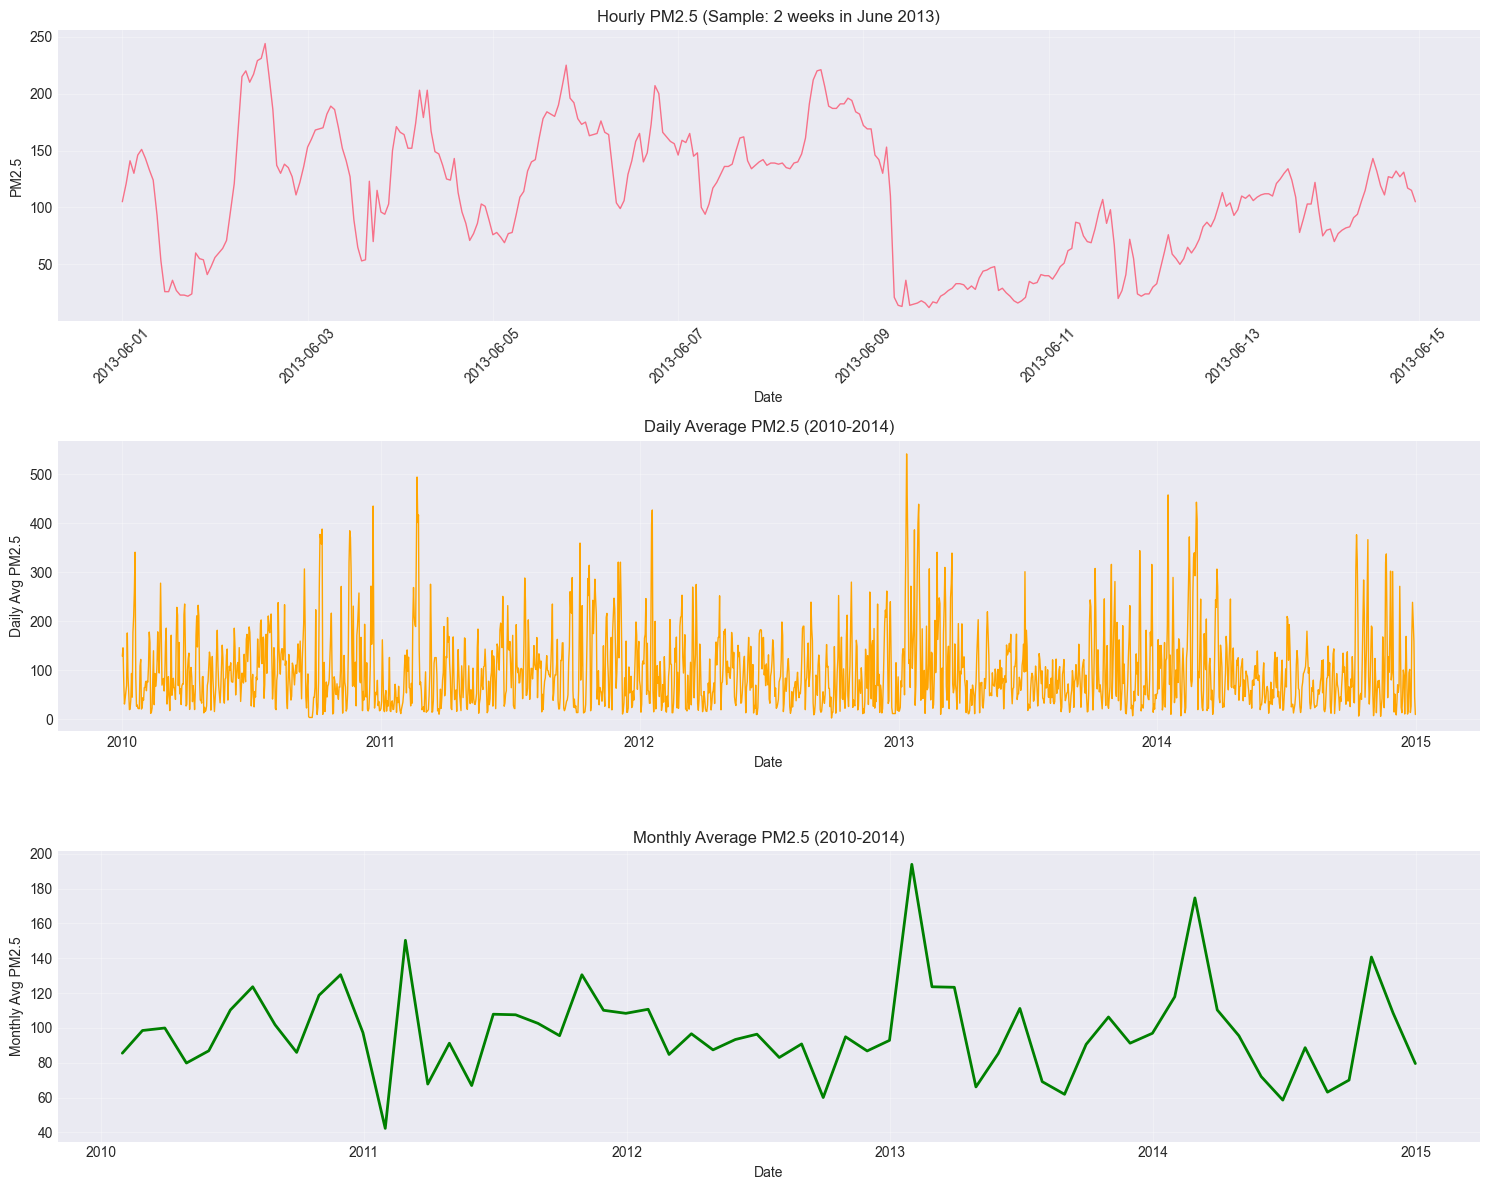


Seasonal Decomposition (Daily Data):


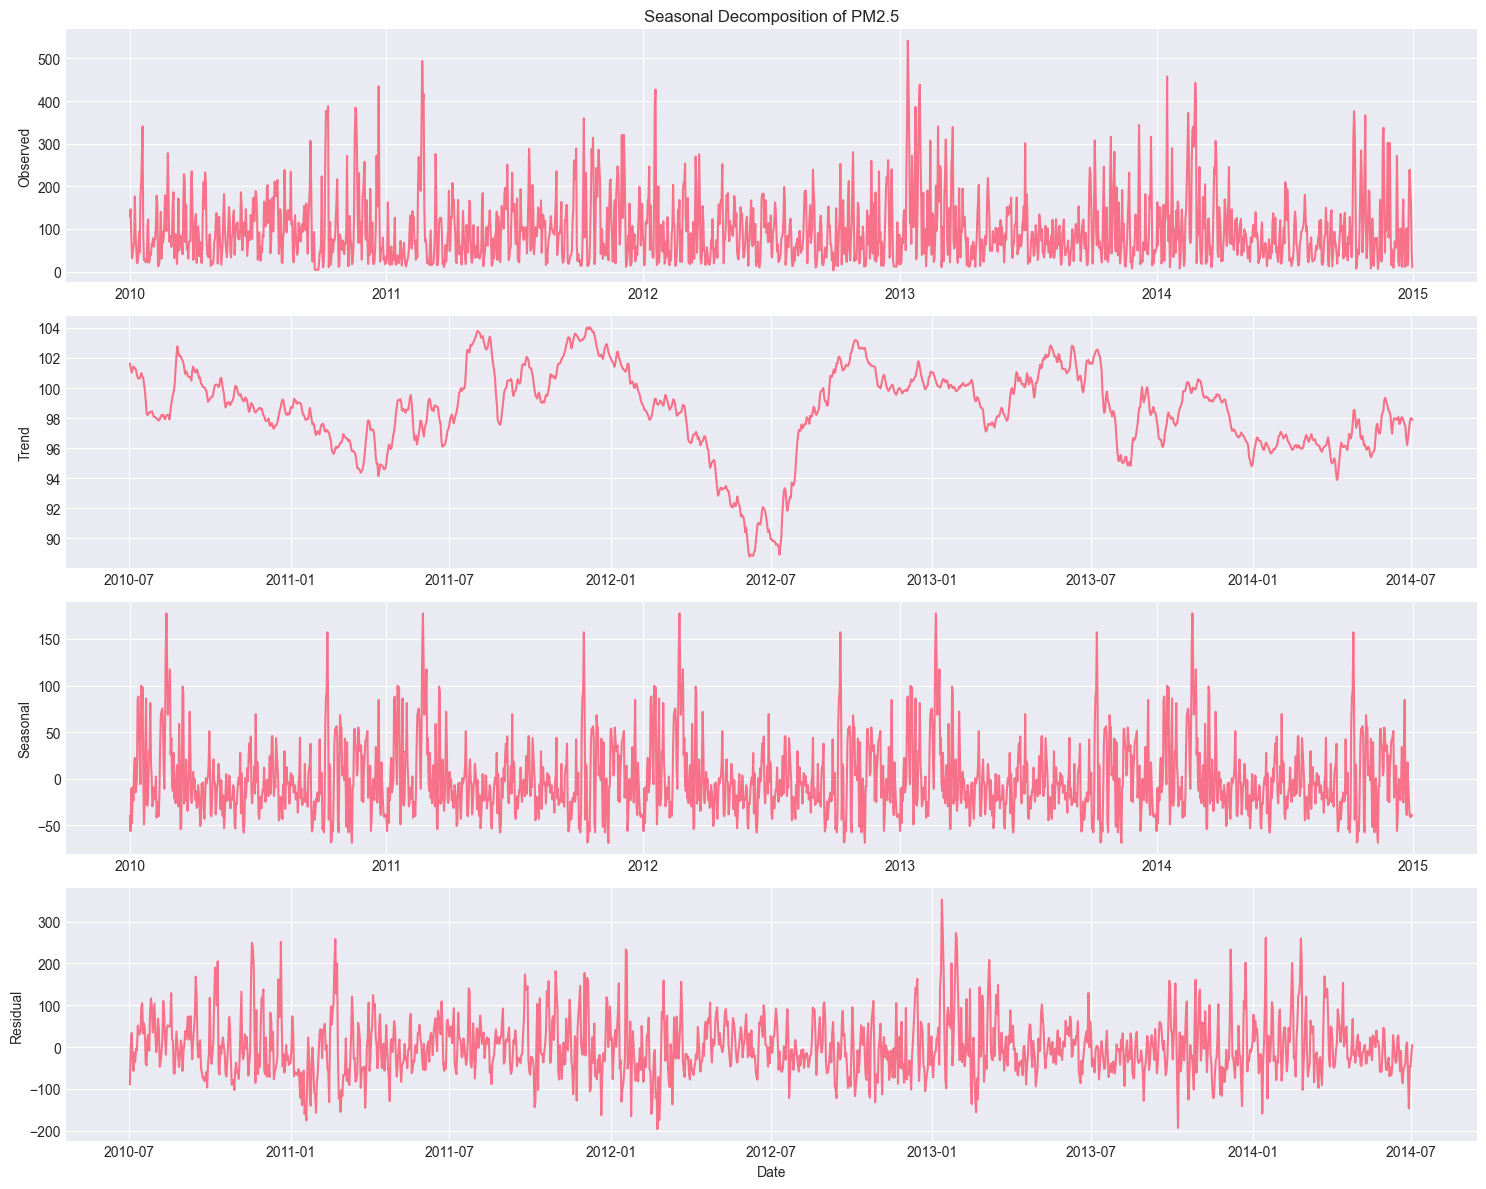

In [9]:
# 6. Time-Series Analysis
print("="*50)
print("TIME-SERIES ANALYSIS")
print("="*50)

# Resample to different frequencies for analysis
df_daily = df['pm2.5'].resample('D').mean()
df_monthly = df['pm2.5'].resample('M').mean()
df_hourly_avg = df.groupby('hour')['pm2.5'].mean()

# Plot time-series at different frequencies
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Hourly (sample 2 weeks)
sample_data = df.loc['2013-06-01':'2013-06-14', 'pm2.5']
axes[0].plot(sample_data.index, sample_data.values, linewidth=1)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('PM2.5')
axes[0].set_title('Hourly PM2.5 (Sample: 2 weeks in June 2013)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Daily average
axes[1].plot(df_daily.index, df_daily.values, linewidth=1, color='orange')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily Avg PM2.5')
axes[1].set_title('Daily Average PM2.5 (2010-2014)')
axes[1].grid(True, alpha=0.3)

# Monthly average
axes[2].plot(df_monthly.index, df_monthly.values, linewidth=2, color='green')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Monthly Avg PM2.5')
axes[2].set_title('Monthly Average PM2.5 (2010-2014)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Seasonal decomposition (using daily data for clarity)
print("\nSeasonal Decomposition (Daily Data):")
try:
    decomposition = seasonal_decompose(df_daily.dropna(), model='additive', period=365)
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    axes[0].plot(decomposition.observed)
    axes[0].set_ylabel('Observed')
    axes[0].set_title('Seasonal Decomposition of PM2.5')
    
    axes[1].plot(decomposition.trend)
    axes[1].set_ylabel('Trend')
    
    axes[2].plot(decomposition.seasonal)
    axes[2].set_ylabel('Seasonal')
    
    axes[3].plot(decomposition.resid)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Decomposition failed: {e}")

DIURNAL & SEASONAL PATTERNS


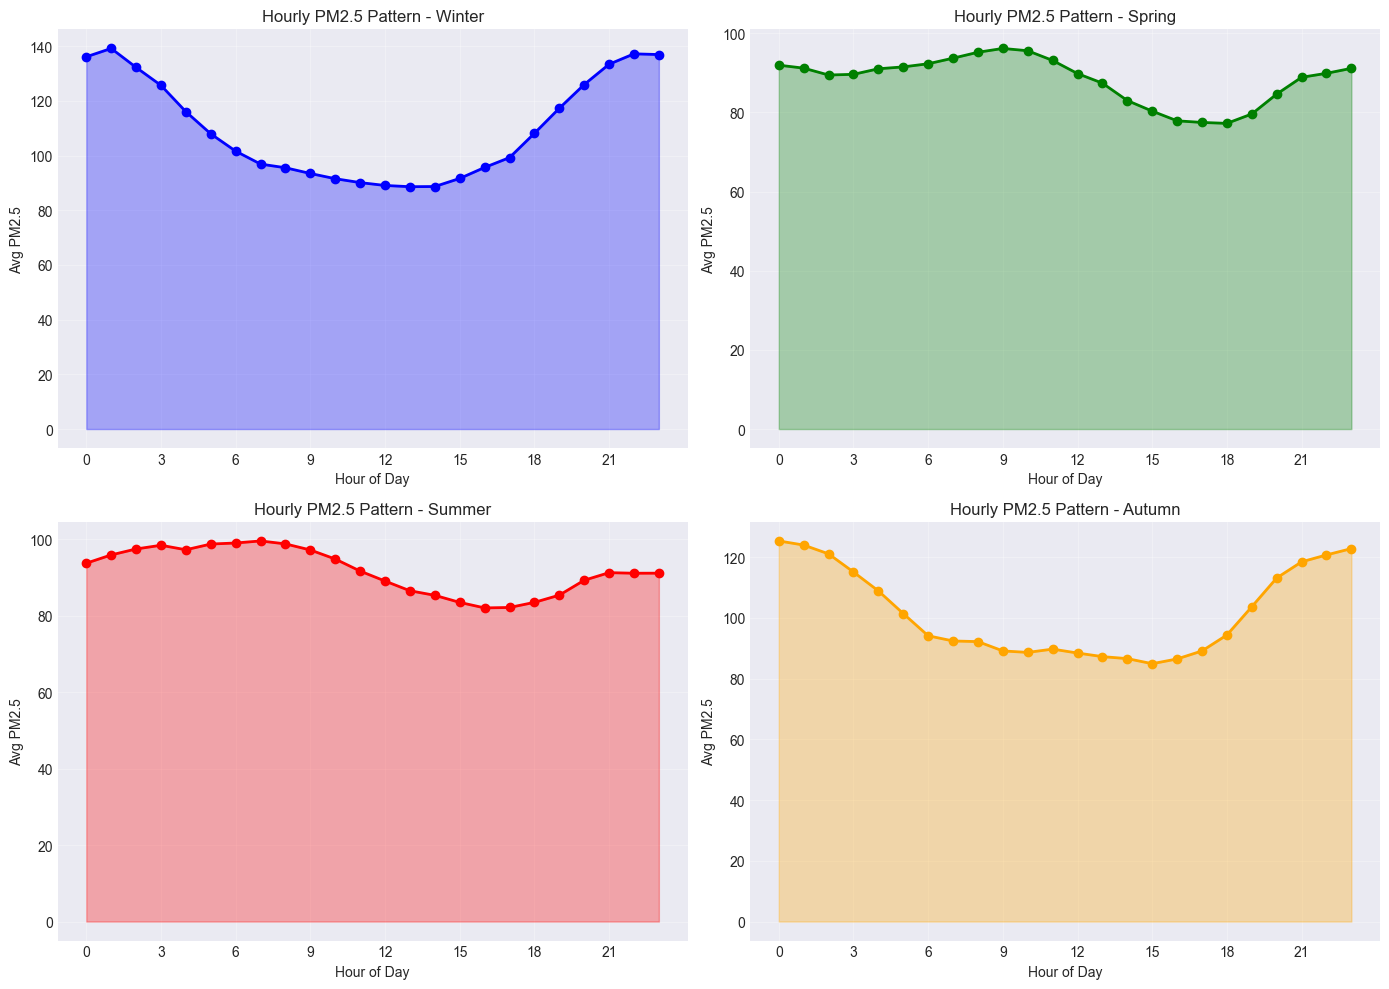

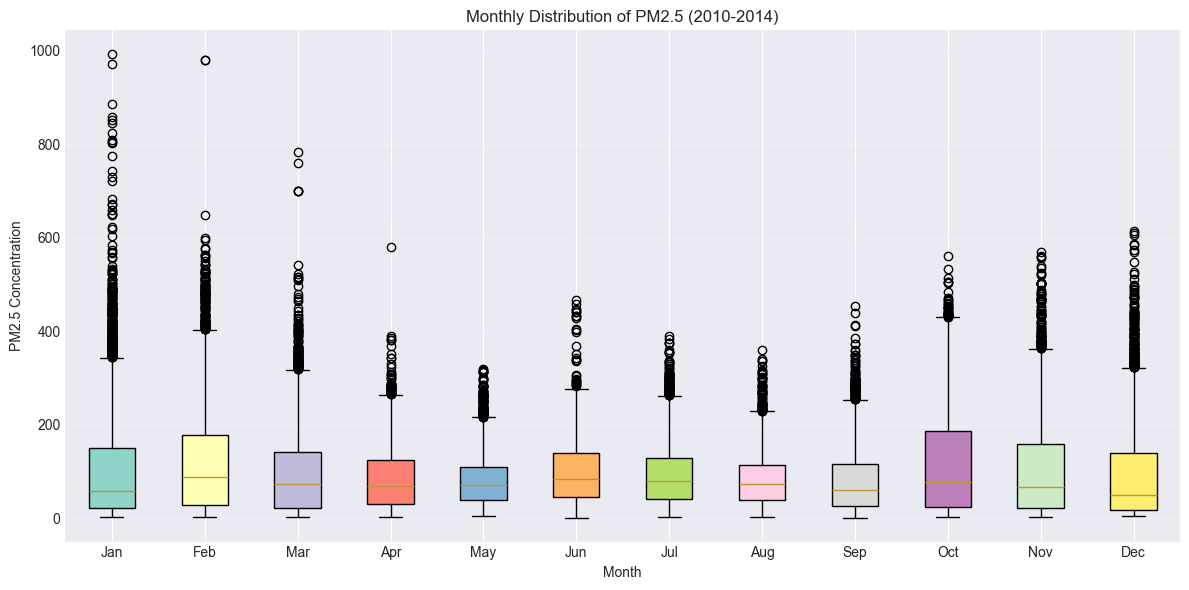

In [10]:
# 7. Diurnal & Seasonal Patterns
print("="*50)
print("DIURNAL & SEASONAL PATTERNS")
print("="*50)

# Hourly patterns by season
df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12,1,2] 
                                 else 'Spring' if x in [3,4,5] 
                                 else 'Summer' if x in [6,7,8] 
                                 else 'Autumn')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
colors = ['blue', 'green', 'red', 'orange']

for idx, season in enumerate(seasons):
    ax = axes[idx//2, idx%2]
    season_data = df[df['season'] == season]
    hourly_avg = season_data.groupby('hour')['pm2.5'].mean()
    
    ax.plot(hourly_avg.index, hourly_avg.values, color=colors[idx], linewidth=2, marker='o')
    ax.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3, color=colors[idx])
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Avg PM2.5')
    ax.set_title(f'Hourly PM2.5 Pattern - {season}')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 3))

plt.tight_layout()
plt.show()

# Monthly boxplot
plt.figure(figsize=(12, 6))
month_order = list(range(1, 13))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

box_data = [df[df['month'] == month]['pm2.5'].values for month in month_order]
box = plt.boxplot(box_data, labels=month_names, patch_artist=True)

# Color boxes
colors = plt.cm.Set3(np.linspace(0, 1, 12))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Month')
plt.ylabel('PM2.5 Concentration')
plt.title('Monthly Distribution of PM2.5 (2010-2014)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

CORRELATION ANALYSIS


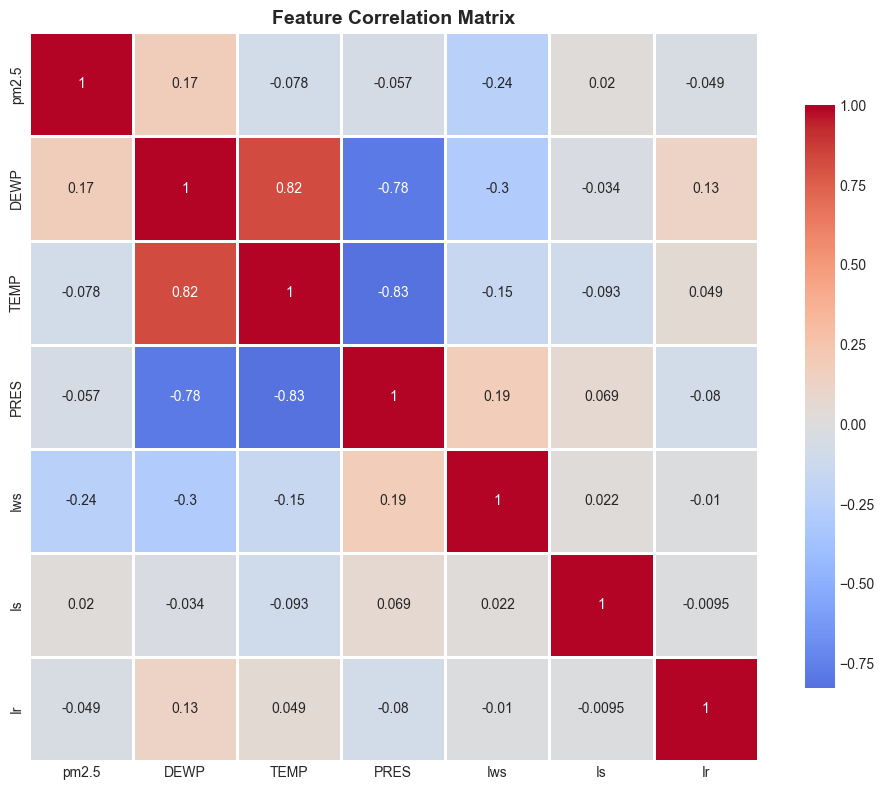


Top correlations with PM2.5:
pm2.5    1.000000
DEWP     0.174881
Is       0.019559
Ir      -0.048810
PRES    -0.057425
TEMP    -0.078106
Iws     -0.243087
Name: pm2.5, dtype: float64


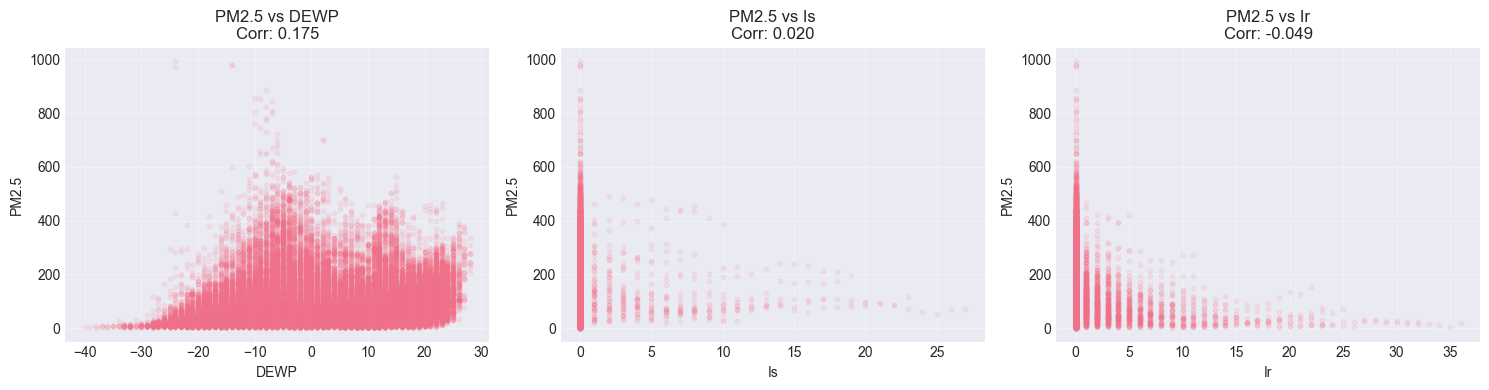

In [11]:
# 8. Correlation Analysis
print("="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Encode categorical variables for correlation
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['cbwd'], prefix='wind')

# Calculate correlations
corr_matrix = df_encoded[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# PM2.5 correlations specifically
print("\nTop correlations with PM2.5:")
pm25_corr = corr_matrix['pm2.5'].sort_values(ascending=False)
print(pm25_corr)

# Scatter plots with top correlated features
top_features = pm25_corr.index[1:4]  # Exclude PM2.5 itself

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, feature in enumerate(top_features):
    axes[idx].scatter(df[feature], df['pm2.5'], alpha=0.1, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('PM2.5')
    axes[idx].set_title(f'PM2.5 vs {feature}\nCorr: {corr_matrix.loc["pm2.5", feature]:.3f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

WIND DIRECTION ANALYSIS
Wind Direction Distribution:
cbwd
SE    15290
NW    14150
cv     9387
NE     4997
Name: count, dtype: int64


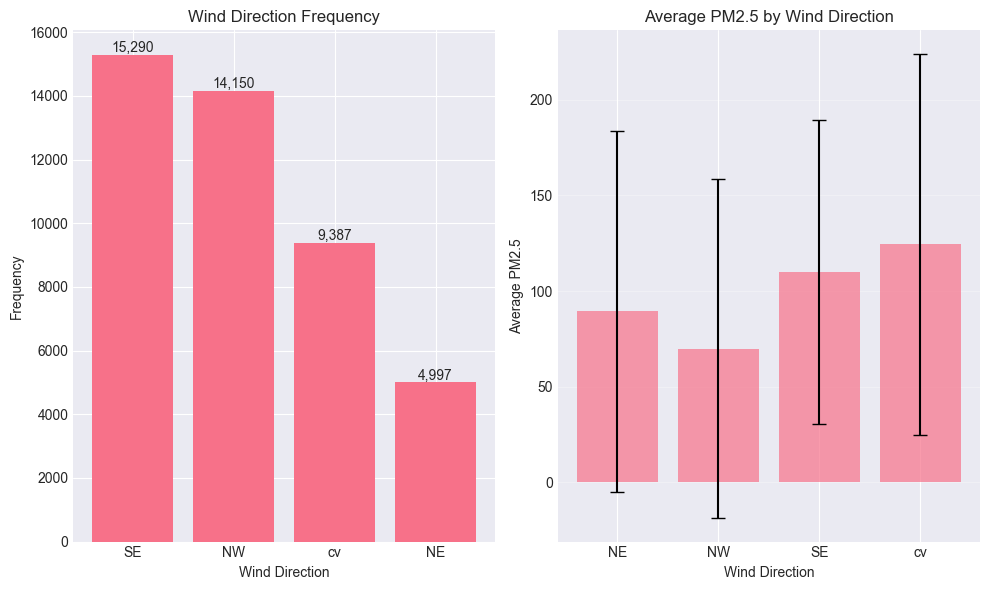

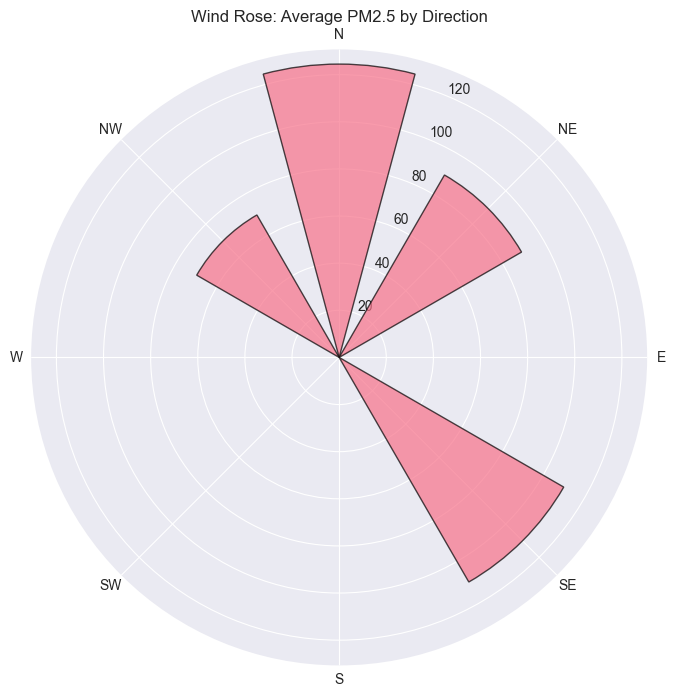

In [12]:
# 9. Wind Direction Analysis
print("="*50)
print("WIND DIRECTION ANALYSIS")
print("="*50)

# Wind direction distribution
wind_counts = df['cbwd'].value_counts()
print(f"Wind Direction Distribution:\n{wind_counts}")

plt.figure(figsize=(10, 6))

# Bar chart
plt.subplot(1, 2, 1)
bars = plt.bar(wind_counts.index, wind_counts.values)
plt.xlabel('Wind Direction')
plt.ylabel('Frequency')
plt.title('Wind Direction Frequency')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}', ha='center', va='bottom')

# PM2.5 by wind direction
plt.subplot(1, 2, 2)
wind_pm25 = df.groupby('cbwd')['pm2.5'].agg(['mean', 'std', 'count'])
bars = plt.bar(wind_pm25.index, wind_pm25['mean'], 
               yerr=wind_pm25['std'], capsize=5, alpha=0.7)
plt.xlabel('Wind Direction')
plt.ylabel('Average PM2.5')
plt.title('Average PM2.5 by Wind Direction')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Wind rose (polar plot)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

# Map wind directions to angles
wind_angle_map = {'NW': 315, 'NE': 45, 'SE': 135, 'SW': 225, 'cv': 0}
angles = [wind_angle_map.get(w, 0) for w in wind_pm25.index]
angles_rad = np.deg2rad(angles)

bars = ax.bar(angles_rad, wind_pm25['mean'], 
              width=np.deg2rad(30), alpha=0.7, 
              edgecolor='black', linewidth=1)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
ax.set_title('Wind Rose: Average PM2.5 by Direction', pad=20)
plt.show()

AUTO-CORRELATION ANALYSIS


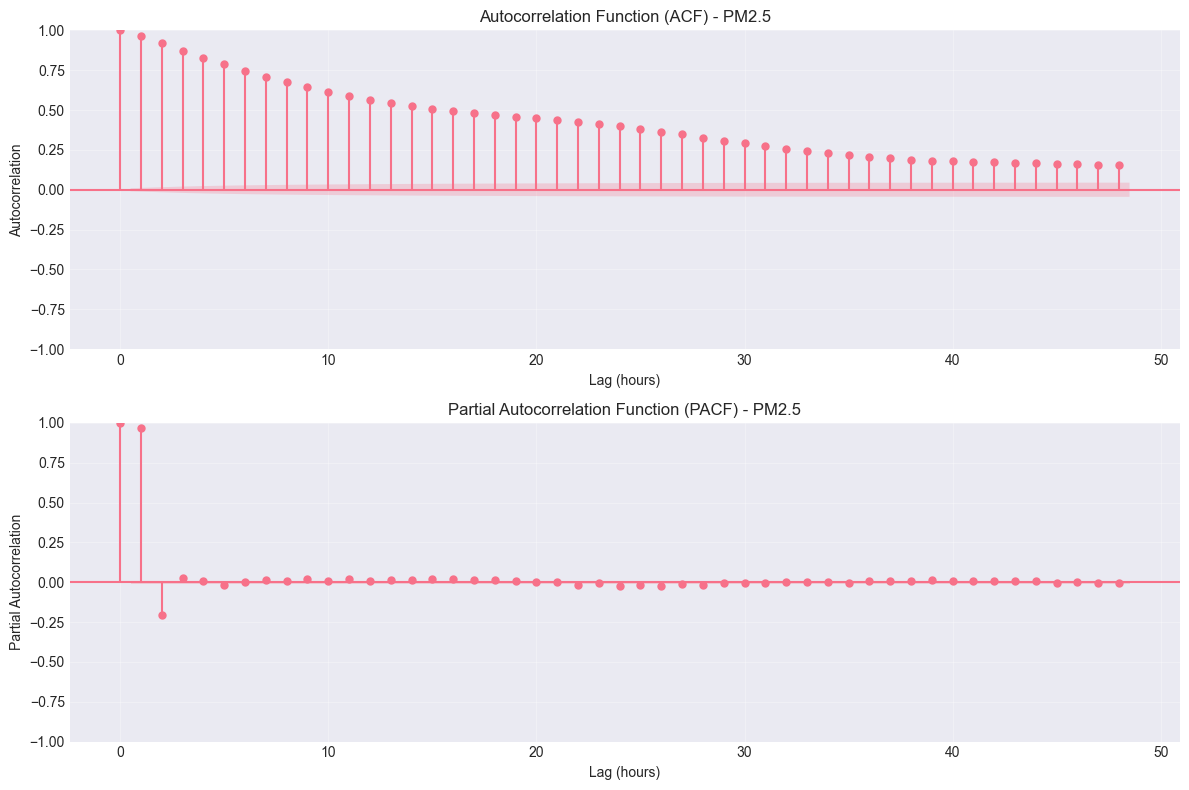


Weekly autocorrelation (lag 168 hours):
Autocorrelation at lag 168 (1 week): 0.0187


In [13]:
# 10. Auto-correlation Analysis
print("="*50)
print("AUTO-CORRELATION ANALYSIS")
print("="*50)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(df['pm2.5'].dropna(), lags=48, ax=axes[0])  # 48 hours = 2 days
axes[0].set_xlabel('Lag (hours)')
axes[0].set_ylabel('Autocorrelation')
axes[0].set_title('Autocorrelation Function (ACF) - PM2.5')
axes[0].grid(True, alpha=0.3)

# PACF plot
plot_pacf(df['pm2.5'].dropna(), lags=48, ax=axes[1], method='ols')
axes[1].set_xlabel('Lag (hours)')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].set_title('Partial Autocorrelation Function (PACF) - PM2.5')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check weekly pattern (168 hours = 7 days)
print("\nWeekly autocorrelation (lag 168 hours):")
from statsmodels.tsa.stattools import acf
acf_values = acf(df['pm2.5'].dropna(), nlags=200)
weekly_corr = acf_values[168] if len(acf_values) > 168 else None
print(f"Autocorrelation at lag 168 (1 week): {weekly_corr:.4f}")

In [14]:
# 11. Summary & Key Insights
print("="*50)
print("EDA SUMMARY & KEY INSIGHTS")
print("="*50)

print("\n1. DATA QUALITY:")
print(f"   • Original missing PM2.5: {original_missing} ({original_missing/len(df)*100:.2f}%)")
print(f"   • After imputation: {df['pm2.5'].isnull().sum()} (0.00%)")
print(f"   • Time range: {df.index.min().date()} to {df.index.max().date()}")
print(f"   • Frequency: Hourly ({len(df)} observations)")

print("\n2. TARGET VARIABLE (PM2.5):")
print(f"   • Mean: {df['pm2.5'].mean():.2f} μg/m³")
print(f"   • Std: {df['pm2.5'].std():.2f} μg/m³")
print(f"   • Min: {df['pm2.5'].min():.2f} μg/m³")
print(f"   • Max: {df['pm2.5'].max():.2f} μg/m³")
print(f"   • Median: {df['pm2.5'].median():.2f} μg/m³")

print("\n3. SEASONAL PATTERNS:")
monthly_avg = df.groupby('month')['pm2.5'].mean()
highest_month = monthly_avg.idxmax()
lowest_month = monthly_avg.idxmin()
print(f"   • Highest pollution: Month {highest_month} ({monthly_avg[highest_month]:.1f} μg/m³)")
print(f"   • Lowest pollution: Month {lowest_month} ({monthly_avg[lowest_month]:.1f} μg/m³)")

print("\n4. DIURNAL PATTERNS:")
hourly_avg = df.groupby('hour')['pm2.5'].mean()
highest_hour = hourly_avg.idxmax()
lowest_hour = hourly_avg.idxmin()
print(f"   • Peak hour: {highest_hour}:00 ({hourly_avg[highest_hour]:.1f} μg/m³)")
print(f"   • Lowest hour: {lowest_hour}:00 ({hourly_avg[lowest_hour]:.1f} μg/m³)")

print("\n5. KEY CORRELATIONS:")
print(f"   • TEMP vs PM2.5: {corr_matrix.loc['pm2.5', 'TEMP']:.3f}")
print(f"   • DEWP vs PM2.5: {corr_matrix.loc['pm2.5', 'DEWP']:.3f}")
print(f"   • PRES vs PM2.5: {corr_matrix.loc['pm2.5', 'PRES']:.3f}")

print("\n6. WIND IMPACT:")
for direction in df['cbwd'].unique():
    avg_pm25 = df[df['cbwd'] == direction]['pm2.5'].mean()
    print(f"   • {direction}: {avg_pm25:.1f} μg/m³")

print("\n7. TIME-SERIES CHARACTERISTICS:")
print("   • Strong autocorrelation at short lags (1-24 hours)")
print("   • Clear seasonal patterns (yearly and daily)")
print("   • Some outliers present (check > 500 μg/m³)")

print("\n8. RECOMMENDATIONS FOR MODELING:")
print("   • Include lag features (1h, 3h, 6h, 12h, 24h)")
print("   • Add time features (hour, month, season, weekday)")
print("   • Consider weather interaction features")
print("   • Handle outliers (winsorize or transform)")
print("   • Use time-series cross-validation")

EDA SUMMARY & KEY INSIGHTS

1. DATA QUALITY:
   • Original missing PM2.5: 2067 (4.72%)
   • After imputation: 0 (0.00%)
   • Time range: 2010-01-01 to 2014-12-31
   • Frequency: Hourly (43824 observations)

2. TARGET VARIABLE (PM2.5):
   • Mean: 97.80 μg/m³
   • Std: 91.38 μg/m³
   • Min: 0.00 μg/m³
   • Max: 994.00 μg/m³
   • Median: 72.00 μg/m³

3. SEASONAL PATTERNS:
   • Highest pollution: Month 2 (126.1 μg/m³)
   • Lowest pollution: Month 9 (80.5 μg/m³)

4. DIURNAL PATTERNS:
   • Peak hour: 1:00 (112.4 μg/m³)
   • Lowest hour: 15:00 (85.0 μg/m³)

5. KEY CORRELATIONS:
   • TEMP vs PM2.5: -0.078
   • DEWP vs PM2.5: 0.175
   • PRES vs PM2.5: -0.057

6. WIND IMPACT:
   • NW: 69.8 μg/m³
   • cv: 124.5 μg/m³
   • NE: 89.4 μg/m³
   • SE: 110.1 μg/m³

7. TIME-SERIES CHARACTERISTICS:
   • Strong autocorrelation at short lags (1-24 hours)
   • Clear seasonal patterns (yearly and daily)
   • Some outliers present (check > 500 μg/m³)

8. RECOMMENDATIONS FOR MODELING:
   • Include lag features 

In [15]:
#12. Save Cleaned Data
# Save cleaned dataset
df.to_csv('beijing_air_quality_cleaned.csv')
print(f"\nCleaned dataset saved: 'beijing_air_quality_cleaned.csv'")
print(f"Final shape: {df.shape}")


Cleaned dataset saved: 'beijing_air_quality_cleaned.csv'
Final shape: (43824, 16)
